In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading in data and looking at values - no changes

In [2]:
## Read in training data

movie_training_data = pd.read_csv('train.csv')

movie_training_data.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [3]:
## Looking at the "belongs to collection" column values. Provides additional data about the collection, which might be useful
## for finding out how sequels impact revenue

movie_training_data.iloc[0,1]

"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]"

In [4]:
## Training Data is 3000 records, with 23 columns.

movie_training_data.shape

(3000, 23)

In [5]:
movie_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [6]:
## Not a lot of correlation between the initial numeric columns

corr_matrix = movie_training_data.corr()

corr_matrix.style.background_gradient(cmap = 'coolwarm')

,id,budget,popularity,runtime,revenue
id,1,0.0197323,-0.00747,0.0107498,0.000609564
budget,0.0197323,1,0.342356,0.238373,0.752965
popularity,-0.00747,0.342356,1,0.13369,0.46146
runtime,0.0107498,0.238373,0.13369,1,0.21638
revenue,0.000609564,0.752965,0.46146,0.21638,1


## Expanding features

#### Looking at film language - heavily skewed to English titles

In [7]:
language_pct_of_revenue = movie_training_data.groupby(['original_language'])['revenue'].sum()
language_pct_of_revenue = language_pct_of_revenue.to_frame().reset_index()

In [8]:
## Calculating total revenue, then figuring out the % of total revenue per language

total_rev = sum(language_pct_of_revenue.revenue)

language_pct_of_revenue['pct_of_total'] = ['%f'%(i/total_rev) for i in language_pct_of_revenue['revenue']]

In [9]:
## Sort values by language - English accounts for 96% of all revenue in our training data

language_pct_of_revenue.sort_values(['pct_of_total'], ascending = False).reset_index(drop = True).head()

,original_language,revenue,pct_of_total
0,en,192264714932,0.960471
1,zh,1337151014,0.006680
2,fr,1336340121,0.006676
3,ja,1134116556,0.005666
4,hi,1064547487,0.005318


#### Exploring cast - the idea that certain actors/actresses bring in revenue

In [10]:
def meta_data_search(regex, column_searched):
    name_search = re.compile(regex)
    return([name_search.findall(str(i)) for i in movie_training_data[column_searched]])

In [11]:
## Cast ID's look to be in descending order based on how they are credited

movie_training_data['cast_ids'] = meta_data_search("\'id\'\:\s(\d+)", "cast")

In [12]:
## Find actor/actress names and append them to a list - accounting for full names that contain between 1-4 names
## Backup option in case id# isn't reliable

movie_training_data['cast_names'] = meta_data_search("\'name\'\:\s\'(\w|\w+\s\w+|\w+\s\w+\s\w+|\w+\s\w+\s\w+\s\w+)\'", "cast")

In [13]:
## Sort through the first 3 elements in the "cast_id" column, then append them in order to the first/second/third lists

first_cast = []
second_cast = []
third_cast = []

for row in movie_training_data.cast_ids:
    if len(row) >= 3:
        first_cast.append(row[0])
        second_cast.append(row[1])
        third_cast.append(row[2])
    elif len(row) == 2:
        first_cast.append(row[0])
        second_cast.append(row[1])
        third_cast.append(np.NaN)
    elif len(row) == 1:
        first_cast.append(row[0])
        second_cast.append(np.NaN)
        third_cast.append(np.NaN)
    else:
        first_cast.append(np.NaN)
        second_cast.append(np.NaN)
        third_cast.append(np.NaN)

In [14]:
## Appending new features to our DataFrame

movie_training_data['first_cast'] = first_cast
movie_training_data['second_cast'] = second_cast
movie_training_data['third_cast'] = third_cast

In [18]:
## Group data by "first_cast", then sum the revenue and create a DataFrame for plotting

star_revenue = movie_training_data.groupby('first_cast')['revenue'].sum()

star_revenue = star_revenue.sort_values(ascending = False)

star_revenue = pd.DataFrame(star_revenue)

star_revenue = star_revenue.reset_index()

In [26]:
## Researching the highest revenue first_cast members shows a 3223 ID that isn't associated with any particular name
## Need to remove any cast_id of 3223 from the dataframe as part of a cleanup

movie_training_data[movie_training_data.first_cast == '3223']

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,title,Keywords,cast,crew,revenue,cast_ids,cast_names,first_cast,second_cast,third_cast
133,134,NaN,65000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://duedatemovie.warnerbros.com/,tt1231583,en,Due Date,Peter Highman must scramble across the US in f...,11.739560,...,Due Date,"[{'id': 3306, 'name': 'highway'}, {'id': 8631,...","[{'cast_id': 18, 'character': 'Peter Highman',...","[{'credit_id': '569c1c83c3a36858c6000d63', 'de...",211780824,"[3223, 58225, 11705, 134, 3196, 62862, 150, 59...","[Zach Galifianakis, Michelle Monaghan, Jamie F...",3223,58225,11705
479,480,NaN,0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",NaN,tt0107091,en,Heart and Souls,A businessman is reunited with the four lost s...,8.450231,...,Heart and Souls,"[{'id': 6155, 'name': 'afterlife'}]","[{'cast_id': 2, 'character': 'Thomas Reilly', ...","[{'credit_id': '52fe44c79251416c75040a5f', 'de...",16589540,"[3223, 28164, 26467, 1951, 3197, 1981]","[Charles Grodin, Kyra Sedgwick, Elisabeth Shue...",3223,28164,26467
1126,1127,"[{'id': 86311, 'name': 'The Avengers Collectio...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/avengers_movie/,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,89.887648,...,The Avengers,"[{'id': 242, 'name': 'new york'}, {'id': 5539,...","[{'cast_id': 46, 'character': 'Tony Stark / Ir...","[{'credit_id': '52fe4495c3a368484e02b1cf', 'de...",1519557910,"[3223, 16828, 103, 74568, 1245, 17604, 91606, ...","[Chris Evans, Mark Ruffalo, Chris Hemsworth, S...",3223,16828,103
1264,1265,NaN,60000000,"[{'id': 18, 'name': 'Drama'}]",http://www.soloistmovie.com,tt0821642,en,The Soloist,A Los Angeles journalist befriends a homeless ...,11.328316,...,The Soloist,"[{'id': 918, 'name': 'newspaper'}, {'id': 3536...","[{'cast_id': 7, 'character': 'Steve Lopez', 'c...","[{'credit_id': '52fe471a9251416c7508dd93', 'de...",31720158,"[3223, 134, 2229, 81697, 81698, 2441, 64908, 4...","[Jamie Foxx, Catherine Keener, Nelsan Ellis, M...",3223,134,2229
1533,1534,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",NaN,tt0094594,en,1969,"Two rebellious youths, Ralph and Scott, find t...",2.238458,...,1969,"[{'id': 2956, 'name': 'vietnam'}, {'id': 6091,...","[{'cast_id': 3, 'character': 'Ralph Carr', 'cr...","[{'credit_id': '52fe4748c3a36847f812cf39', 'de...",5979011,"[3223, 2628, 6905, 16131, 1920, 593, 2455]","[Kiefer Sutherland, Bruce Dern, Mariette Hartl...",3223,2628,6905
2770,2771,"[{'id': 86311, 'name': 'The Avengers Collectio...",280000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://marvel.com/movies/movie/193/avengers_ag...,tt2395427,en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,37.379420,...,Avengers: Age of Ultron,"[{'id': 8828, 'name': 'marvel comic'}, {'id': ...","[{'cast_id': 76, 'character': 'Tony Stark / Ir...","[{'credit_id': '55d5f7d4c3a3683e7e0016eb', 'de...",1405403694,"[3223, 74568, 103, 16828, 1245, 17604, 13548, ...","[Chris Hemsworth, Mark Ruffalo, Chris Evans, S...",3223,74568,103


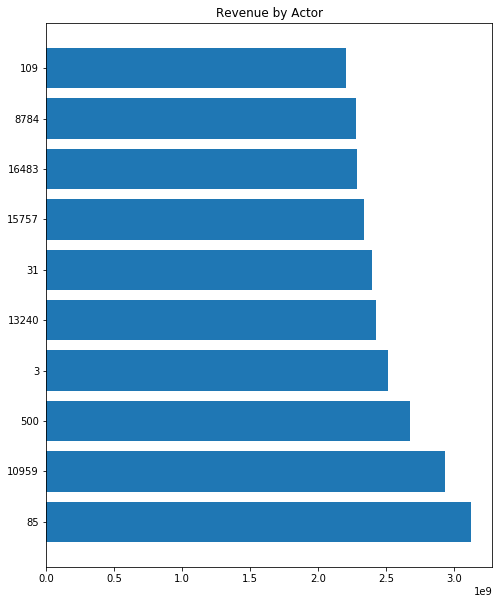

In [22]:
## Plotting the top 10 revenue-producing first_cast

plt.figure(figsize = (8, 10))
plt.barh('first_cast', 'revenue', data = star_revenue[1:11])
plt.title('Revenue by Actor');